In [85]:
import os
import numpy as np
import matplotlib.pyplot as plt
from gensim.models.word2vec import PathLineSentences, LineSentence, Word2Vec
from pathlib import Path
import networkx as nx
from sklearn import model_selection, linear_model, preprocessing, svm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import make_pipeline
%matplotlib inline

In [6]:
import sys
sys.path.append("/Users/doc019/Code/stellar-evaluation-plugins")
from utils.epgm import EPGM

ModuleNotFoundError: No module named 'utils'

**Load random walks from output files**

The word2vec model requires sentences of strings, so we convert node number to a string.

In [223]:
rw_location = Path("/Users/Ganymedian/Desktop/dynamic-rw/karate/remove-runs")
methods = ["m1", "m2", "m3", "m4"]
nmethods = len(methods)
vertices = []
for i in range(34):
    vertices.append("v"+str(i+1))
v = vertices[2]

In [224]:
G = nx.karate_club_graph()
n_nodes = G.number_of_nodes()
A = nx.adjacency_matrix(G).toarray()
d_w = A.sum(axis=0)
M_theory = A.T / d_w

In [225]:
random_walks_int = []

for m in methods:
    fname = m
    if m != "m1":
        fname = fname+"-"+v
    print(fname)
    rws = np.concatenate([
        np.loadtxt(f.open(), delimiter='\t', dtype=int)
        for f in rw_location.glob(fname+"-*/part-*")
        if f.stat().st_size > 0
    ])
    print(rws.shape)
    random_walks_int.append(rws)
#     random_walks_str = [list(map(str, v)) for v in random_walks_int]

m1
(17000, 101)
m2-v3
(17000, 101)
m3-v3
(17000, 101)
m4-v3
(17000, 101)


In [226]:
all_runs = []
for i in range(nmethods):
    ars = np.vsplit(random_walks_int[i], 5)
    print(ars[0].shape)
    all_runs.append(ars)


(3400, 101)
(3400, 101)
(3400, 101)
(3400, 101)


<function matplotlib.pyplot.show>

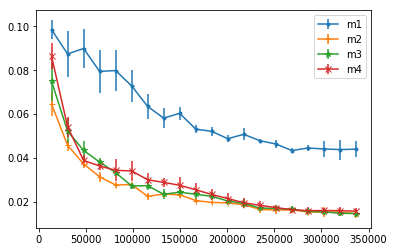

In [227]:
formats=['.-', '+-', '*-','x-']
for mm in range(nmethods):
    all_errors = []
    walk_length = all_runs[mm][0].shape[1]
    for rr in range(5):
        errors = []
        x_axis = []
        for ii in range(20):
            walk_length = 5*(ii + 1)

            M_empirical = np.zeros((n_nodes, n_nodes))
            for walk in all_runs[mm][rr]:
                for kk in range(walk_length - 1):
                    M_empirical[walk[kk] - 1, walk[kk + 1] - 1] += 1

            n_samples = M_empirical.sum()
            M_empirical = M_empirical.T / np.maximum(M_empirical.sum(axis=1), 1)

            errors.append(np.abs(M_theory - M_empirical).max())
            x_axis.append(n_samples)
        all_errors.append(errors)
    n = len(all_errors)
    means = np.sum(all_errors, axis=0)/n
    stdv = np.sqrt(np.sum(np.square(all_errors-means),axis=0)/(n-1))
    stderr = stdv/np.sqrt(n)
    plt.errorbar(x_axis, means, yerr=stderr, fmt=formats[mm], label=methods[mm])
    plt.legend()
plt.show
# plt.plot(x_axis, all_errors, '.-')

<function matplotlib.pyplot.show>

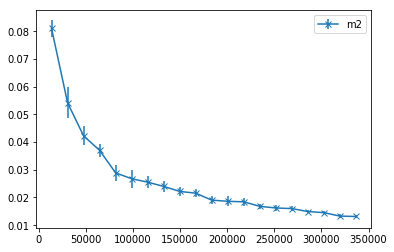

<function matplotlib.pyplot.show>

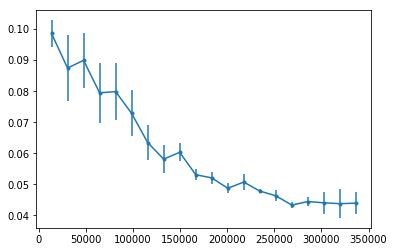

[[0.09896907216494844,
  0.06491228070175442,
  0.07083333333333336,
  0.08098591549295775,
  0.09787422497785653,
  0.06548498276710979,
  0.06672418751797526,
  0.05519125683060111,
  0.06090373280943029,
  0.0602045560204556,
  0.05229591836734693,
  0.04464285714285715,
  0.056704707560627676,
  0.046875,
  0.04980211081794195,
  0.04194528875379944,
  0.048213272830402776,
  0.05406118143459915,
  0.060871743486973995,
  0.05600571973307911],
 [0.09062500000000001,
  0.0755968169761273,
  0.0834164174144234,
  0.06946039035591278,
  0.07415078707539358,
  0.0709318497913769,
  0.06120125249074865,
  0.05251141552511418,
  0.05957836846929421,
  0.05000521975153982,
  0.0479394449116905,
  0.04998141954663693,
  0.04557869580061458,
  0.047214353163361644,
  0.045432904849350475,
  0.044228493116551415,
  0.04648862512363999,
  0.04691358024691361,
  0.04304928078101472,
  0.044441134117880754],
 [0.09041394335511982,
  0.11757719714964371,
  0.1152694610778443,
  0.087951807228915

array([[ 4.09095577e-04, -2.25299212e-02, -1.90852618e-02,
         1.52112840e-03,  1.80070799e-02, -7.35162738e-03,
         3.25319332e-03, -2.93906718e-03,  5.80120102e-04,
         7.08744139e-03,  2.05212953e-04, -4.11430028e-03,
         5.96978582e-03, -9.74318649e-04,  3.47183272e-03,
        -1.38941124e-03,  3.72704969e-03,  9.99060787e-03,
         1.70831717e-02,  1.20498152e-02],
       [-7.93497659e-03, -1.18453849e-02, -6.50217774e-03,
        -1.00043967e-02, -5.71635802e-03, -1.90476036e-03,
        -2.26974171e-03, -5.61890849e-03, -7.45244238e-04,
        -3.11189488e-03, -4.15126050e-03,  1.22426212e-03,
        -5.15622594e-03, -6.34965486e-04, -8.97373245e-04,
         8.93793121e-04,  2.00240198e-03,  2.84300668e-03,
        -7.39290993e-04,  4.85229606e-04],
       [-8.14603323e-03,  3.01349952e-02,  2.53508659e-02,
         8.48702014e-03, -1.72873239e-02, -9.65971484e-03,
        -1.09814921e-02, -8.34445677e-03, -1.05930885e-02,
        -1.69867492e-03,  1.8

Calculate empirical transition probabilities

In [24]:
random_walks_int[random_walks_int[:, 0] == 1]

array([[ 1,  2, 14, ..., 29, 32, 29],
       [ 1, 32, 33, ..., 34, 15, 34],
       [ 1,  5,  7, ...,  3, 28, 25],
       ...,
       [ 1,  9, 33, ...,  2,  4,  1],
       [ 1, 18,  1, ...,  6,  7, 17],
       [ 1, 20,  2, ...,  4,  2,  1]])

In [83]:
errors = []
x_axis = []
walk_length = random_walks_int.shape[1]
for ii in range(20):
    walk_length = 5*(ii + 1)
    walk_lengths.append(walk_length)
    
    M_empirical = np.zeros((n_nodes, n_nodes))
    for walk in random_walks_int:
        for kk in range(walk_length - 1):
            M_empirical[walk[kk] - 1, walk[kk + 1] - 1] += 1

    n_samples = M_empirical.sum()
    M_empirical = M_empirical.T / np.maximum(M_empirical.sum(axis=1), 1)

    errors.append(np.abs(M_theory - M_empirical).max())
    x_axis.append(n_samples)

plt.plot(x_axis, errors, '.-')

NameError: name 'walk_lengths' is not defined

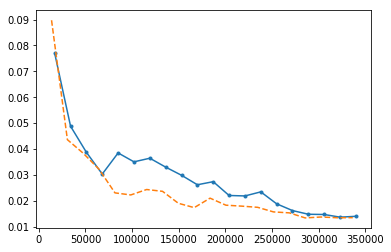

In [68]:
errors_nw = []
x_axis_nw = []
walk_length = random_walks_int.shape[1]
for ii in range(20):
    #walk_length = 5*(ii + 1)
    #walk_lengths.append(walk_length)
    
    num_walks = 5*(ii + 1)

    reduced_walks = []
    for kk in range(1, n_nodes+1):
        reduced_walks.append(
            random_walks_int[random_walks_int[:, 0] == kk][:num_walks]
        )
    reduced_walks = np.concatenate(reduced_walks)
    
    M_empirical = np.zeros((n_nodes, n_nodes))
    for walk in reduced_walks:
        for kk in range(walk_length - 1):
            M_empirical[walk[kk] - 1, walk[kk + 1] - 1] += 1
    n_samples = M_empirical.sum()
    M_empirical = M_empirical.T / np.maximum(M_empirical.sum(axis=1), 1)

    errors_nw.append(np.abs(M_theory - M_empirical).max())
    x_axis_nw.append(n_samples)

plt.plot(x_axis_nw, errors_nw, '.-')
plt.plot(x_axis, errors, '--')

Theoretical transition probabilities

In [76]:
plt.imshow(np.abs(M_theory - M_empirical))
plt.colorbar()

NameError: name 'M_empirical' is not defined

In [47]:
error = np.abs(M_theory - M_empirical).max()
#error = np.linalg.norm(M_theory - M_empirical)
error

0.013974096796182667

Train word2vec embeddings using gensim

In [239]:
model = Word2Vec(random_walks_str, sg=1, size=20, window=5, sample=0, min_count=0, 
                 workers=4, seed=1321, iter=10, compute_loss=True)

In [240]:
model.get_latest_training_loss()

53827.1953125

Save embeddings

In [228]:
model.wv.save_word2vec_format("embeddings.out")

Extract embeddings as matrix of size `n_nodes` × `d`

In [241]:
V_w2v = model.wv.syn0
n_nodes, d_emb = V_w2v.shape

Node labels:

In [242]:
node_labels = np.zeros(n_nodes)
node_labels[:10] = 1

**Classification using single train/test split**

In [243]:
# Split using sklearn ShuffleSplit
ss = model_selection.ShuffleSplit(n_splits=1,
                                  train_size=0.6,
                                  test_size=0.4)
train_index, test_index = next(ss.split(V_w2v))

train_data = V_w2v[train_index]
test_data = V_w2v[test_index]
train_labels = node_labels[train_index]
test_labels  = node_labels[test_index]

# Classifier choice
#classifier = linear_model.LogisticRegression(C=10)
classifier = svm.SVC(C=1)

clf = make_pipeline(preprocessing.StandardScaler(), classifier)
clf.fit(train_data, train_labels)

train_pred = clf.predict(train_data)
test_pred = clf.predict(test_data)

print("Train acc:", clf.score(train_data, train_labels))
print("Test acc:", clf.score(test_data, test_labels))
print("Train f1:", f1_score(train_labels, train_pred, average='micro'))
print("Test f1:", f1_score(test_labels, test_pred, average='micro'))

Train acc: 0.85
Test acc: 0.642857142857
Train f1: 0.85
Test f1: 0.642857142857


**K-fold cross validation**

In [244]:
kf = model_selection.KFold(n_splits=4, shuffle=True)

acc_test_scores = []
f1_test_scores = []
for train_index, test_index in kf.split(V_w2v):
    train_data = V_w2v[train_index]
    test_data = V_w2v[test_index]
    train_labels = node_labels[train_index]
    test_labels  = node_labels[test_index]
    
    # Classifier choice
    #classifier = linear_model.LogisticRegression(C=10)
    classifier = svm.SVC(C=1)

    clf = make_pipeline(preprocessing.StandardScaler(), classifier)
    clf.fit(train_data, train_labels)

    train_pred = clf.predict(train_data)
    test_pred = clf.predict(test_data)

    acc_train = clf.score(train_data, train_labels)
    acc_test = clf.score(test_data, test_labels)
    f1_train = f1_score(train_labels, train_pred, average='micro')
    f1_test = f1_score(test_labels, test_pred, average='micro')
    
    acc_test_scores.append(acc_test)
    f1_test_scores.append(f1_test)
    
    print("Train acc={:4f},  Test acc={:4f},  Train f1={:4f},  Test f1={:4f}".format(
        acc_train, acc_test, f1_train, f1_test
    ))
    
print("Average scores:")
print("Avg test acc={:4f} [±{:2f}],  Avg test f1={:4f} [±{:2f}]".format(
    np.mean(acc_test_scores), np.std(acc_test_scores), 
    np.mean(f1_test_scores), np.std(f1_test_scores)
))

Train acc=0.800000,  Test acc=0.666667,  Train f1=0.800000,  Test f1=0.666667
Train acc=0.880000,  Test acc=0.666667,  Train f1=0.880000,  Test f1=0.666667
Train acc=0.769231,  Test acc=0.750000,  Train f1=0.769231,  Test f1=0.750000
Train acc=0.807692,  Test acc=0.750000,  Train f1=0.807692,  Test f1=0.750000
Average scores:
Avg test acc=0.708333 [±0.041667],  Avg test f1=0.708333 [±0.041667]
